# Competición kaggle RSNA MICCAI BRAIN TUMOR RADIOGENOMIC CLASSIFICATION

## EDA

Carga librerias

In [1]:
import os
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import pydicom as dicom
import cv2
import ast

import warnings
warnings.filterwarnings("ignore")

Ruta del dataset

In [2]:
path = '../data/rsna-miccai-brain-tumor-radiogenomic-classification/'

os.listdir(path)

['sample_submission.csv', 'train_labels.csv', 'train', 'test']

Carga dataset

In [8]:
train_data = pd.read_csv(path+'train_labels.csv')
samp_subm = pd.read_csv(path+'sample_submission.csv')

print('Samples train:', len(train_data))
print('Samples test:', len(samp_subm))

train_data.head()

Samples train: 585
Samples test: 87


,BraTS21ID,MGMT_value
0,0,1
1,2,1
2,3,0
3,5,1
4,6,1


1    307
0    278
Name: MGMT_value, dtype: int64

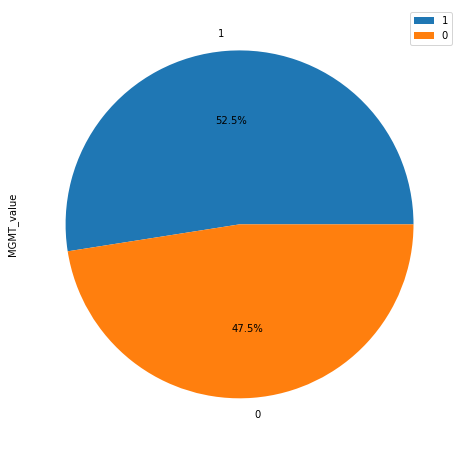

In [16]:
train_data["MGMT_value"].value_counts().head(2).plot(kind = 'pie', autopct='%1.1f%%', figsize=(8, 8)).legend()
train_data["MGMT_value"].value_counts()

In [17]:
samp_subm.head()

,BraTS21ID,MGMT_value
0,1,0.5
1,13,0.5
2,15,0.5
3,27,0.5
4,37,0.5


Extraemos el id de la carpeta para el primer ejemplo de entrenamiento

In [18]:
folder = str(train_data.loc[0, 'BraTS21ID']).zfill(5)
folder

'00000'

In [20]:
os.listdir(path+'train/'+folder)

['FLAIR', 'T2w', 'T1wCE', 'T1w']

In [21]:
print('Number of FLAIR images:', len(os.listdir(path+'train/'+folder+'/'+'FLAIR')))
print('Number of T1w images:', len(os.listdir(path+'train/'+folder+'/'+'T1w')))
print('Number of T1wCE images:', len(os.listdir(path+'train/'+folder+'/'+'T1wCE')))
print('Number of T2w images:', len(os.listdir(path+'train/'+folder+'/'+'T2w')))

Number of FLAIR images: 400
Number of T1w images: 33
Number of T1wCE images: 129
Number of T2w images: 408


Leer imagen

In [22]:
path_file = ''.join([path, 'train/', folder, '/', 'FLAIR/'])
image = os.listdir(path_file)[0]
data_file = dicom.dcmread(path_file+image)
img = data_file.pixel_array

In [25]:
img.shape

(512, 512)

Imágenes Flair

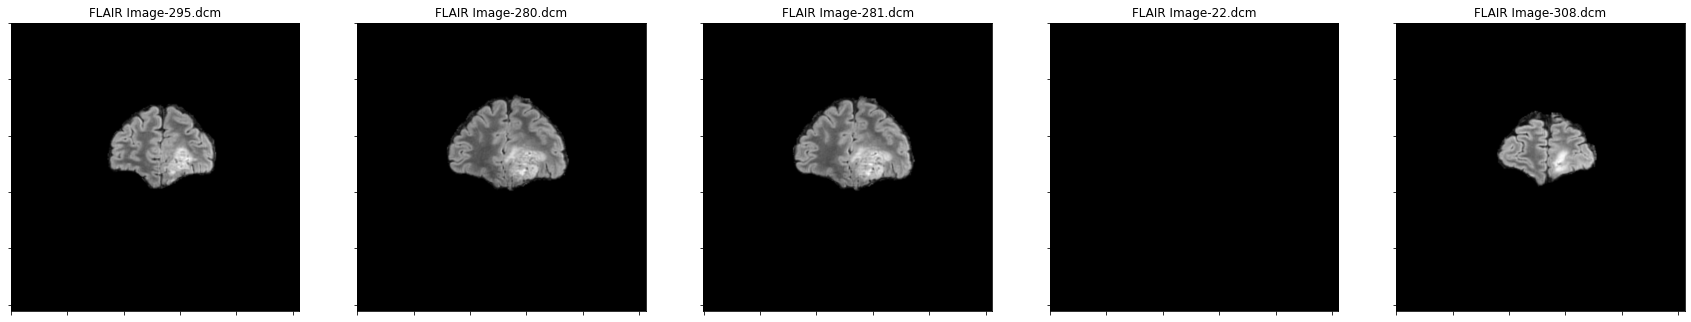

In [34]:
def plot_examples(row = 0, cat = 'FLAIR'): 
    folder = str(train_data.loc[row, 'BraTS21ID']).zfill(5)
    path_file = ''.join([path, 'train/', folder, '/', cat, '/'])
    images = os.listdir(path_file)
    
    fig, axs = plt.subplots(1, 5, figsize=(30, 30))
    fig.subplots_adjust(hspace = .2, wspace=.2)
    axs = axs.ravel()
    
    for num in range(5):
        data_file = dicom.dcmread(path_file+images[num])
        img = data_file.pixel_array
        axs[num].imshow(img, cmap='gray')
        axs[num].set_title(cat+' '+images[num])
        axs[num].set_xticklabels([])
        axs[num].set_yticklabels([])
        
row = 0
plot_examples(row = row, cat = 'FLAIR')

Imágenes T1w

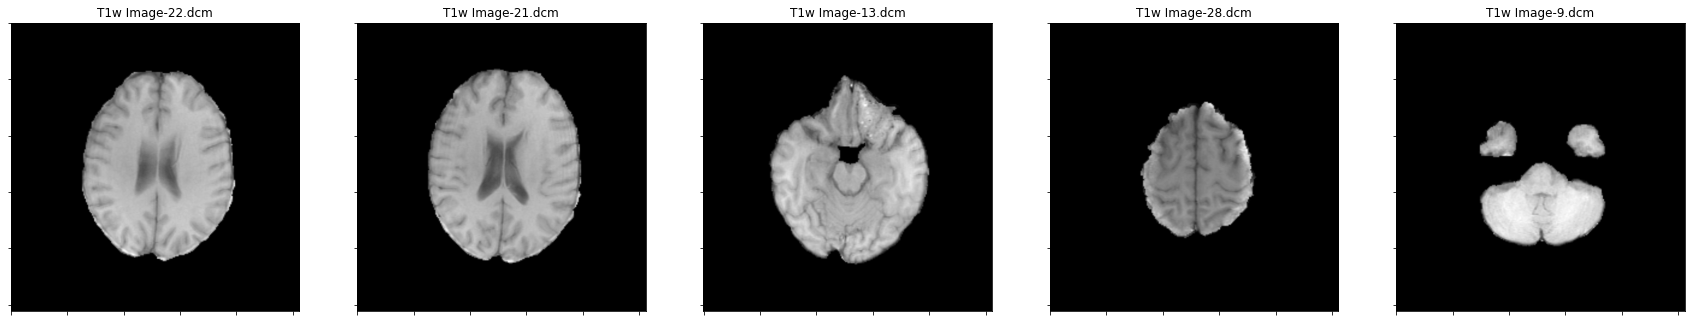

In [27]:
plot_examples(row = row, cat = 'T1w')

Imágenes T1wCE

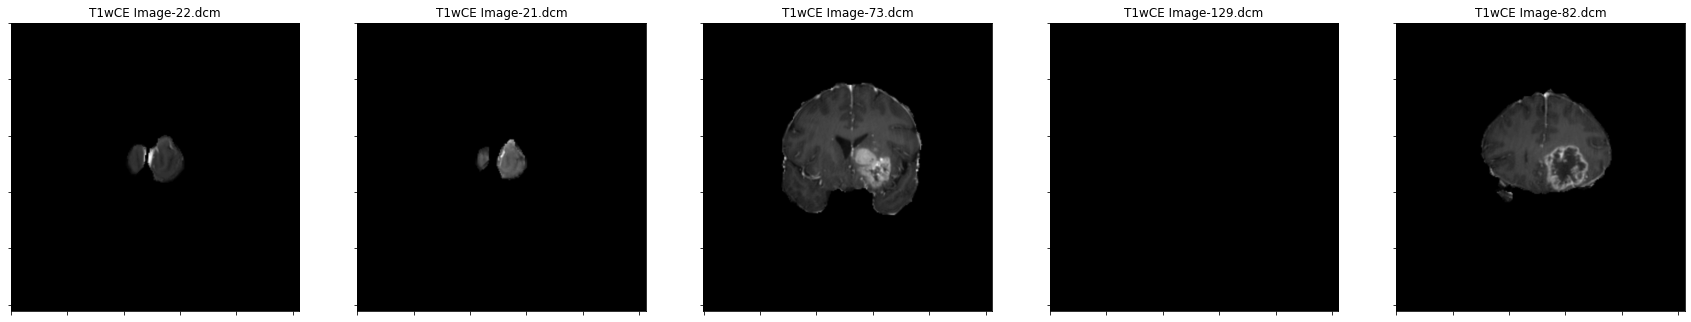

In [28]:
plot_examples(row = row, cat = 'T1wCE')

Imágenes T2w

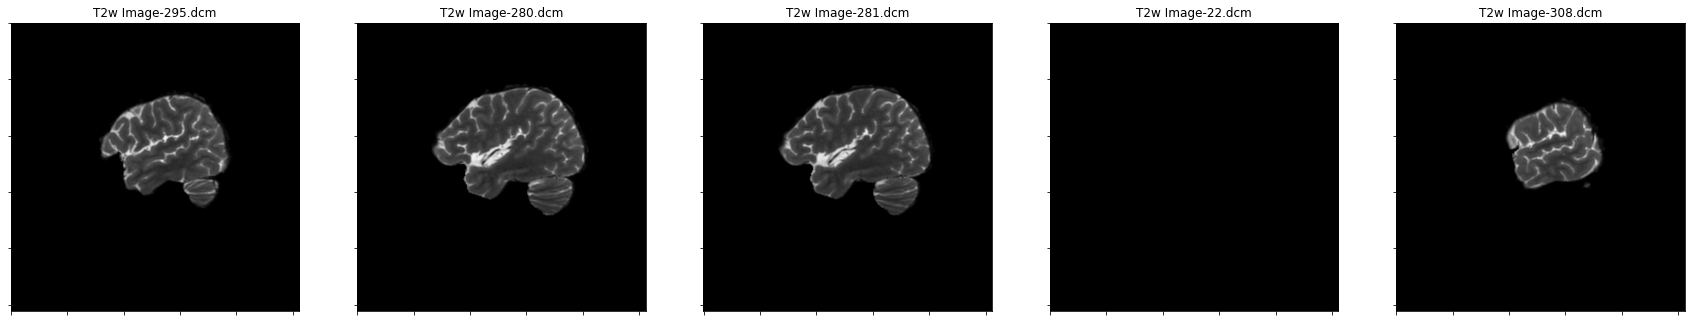

In [29]:
plot_examples(row = row, cat = 'T2w')

# 3D image visualization | From pixels to voxels

In [5]:
import os
import glob
from tqdm import tqdm
from random import randint

import numpy as np
import pydicom

import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib.animation as anim
import matplotlib.patches as mpatches
import matplotlib.gridspec as gridspec


import imageio
from skimage.transform import resize
from skimage.util import montage

from IPython.display import Image as show_gif

import warnings
warnings.simplefilter("ignore")

In [7]:
path = '../data/rsna-miccai-brain-tumor-radiogenomic-classification/'
sample_id = path + '/train/00000'
path_x = sample_id + '/T2w/*.dcm'
start = len(sample_id + '/T2w/Image-')
end = len('.dcm')
path_to_slices = sorted(glob.glob(path_x), key= lambda x: int(x[start:-end]))

## Representación cerebro por slices

MovieWriter imagemagick unavailable; using Pillow instead.


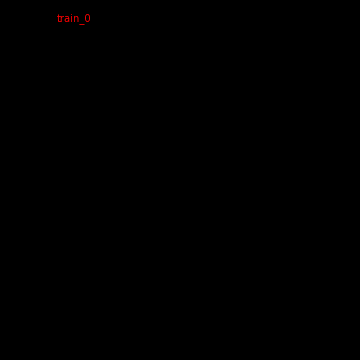

In [36]:
class ImageToGIF:
    """Create GIF without saving image files."""
    def __init__(self,
                 size=(500, 500), 
                 xy_text=(80, 30),
                 dpi=100, 
                 cmap='CMRmap'):

        self.fig = plt.figure()
        self.fig.set_size_inches(size[0] / dpi, size[1] / dpi)
        self.xy_text = xy_text
        self.cmap = cmap
        
        self.ax = self.fig.add_axes([0, 0, 1, 1])
        self.ax.set_xticks([])
        self.ax.set_yticks([])
        self.images = []
 
    def add(self, image, label, with_mask=False):
        plt.set_cmap(self.cmap)
        plt_img = self.ax.imshow(image, animated=True)
        plt_text = self.ax.text(*self.xy_text, label, color='red')
        to_plot = [plt_img, plt_text]
        self.images.append(to_plot)
        plt.close()
 
    def save(self, filename, fps):
        animation = anim.ArtistAnimation(self.fig, self.images)
        animation.save(filename, writer='imagemagick', fps=fps)
        

sample_data_gif = ImageToGIF()
label = sample_id.replace('/', '.').split('.')[-2]
filename = f'{label}_3d_2d.gif'

for i in range(len(path_to_slices)):
    image = pydicom.read_file(path_to_slices[i]).pixel_array
    #mask = np.clip(np.rot90(sample_mask[i]), 0, 1)
    sample_data_gif.add(image, label=f'{label}_{str(i)}')

    
sample_data_gif.save(filename, fps=15)
show_gif(filename, format='png')